In [1]:
from comet_ml import Experiment
# import tensorflow as tf
# gpus = tf.config.list_physical_devices('GPU')
# print("GPUs disponibles:", gpus)


In [2]:
import numpy as np
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
# !git clone https://github.com/emiliodelgadouy/utils.git

In [3]:
from matplotlib import pyplot as plt
from utils.PatchSequence import PatchSequence
from utils.Dataset import Dataset

2025-08-12 23:16:10.503036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755051370.564825  112955 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755051370.582251  112955 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755051370.701209  112955 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755051370.701238  112955 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755051370.701239  112955 computation_placer.cc:177] computation placer alr

In [4]:
dataset = Dataset(lateralize=True, dataset_csv="dataset_balanced.csv")

Flip BBoxes: 100%|██████████| 5858/5858 [00:00<00:00, 7265.59it/s]


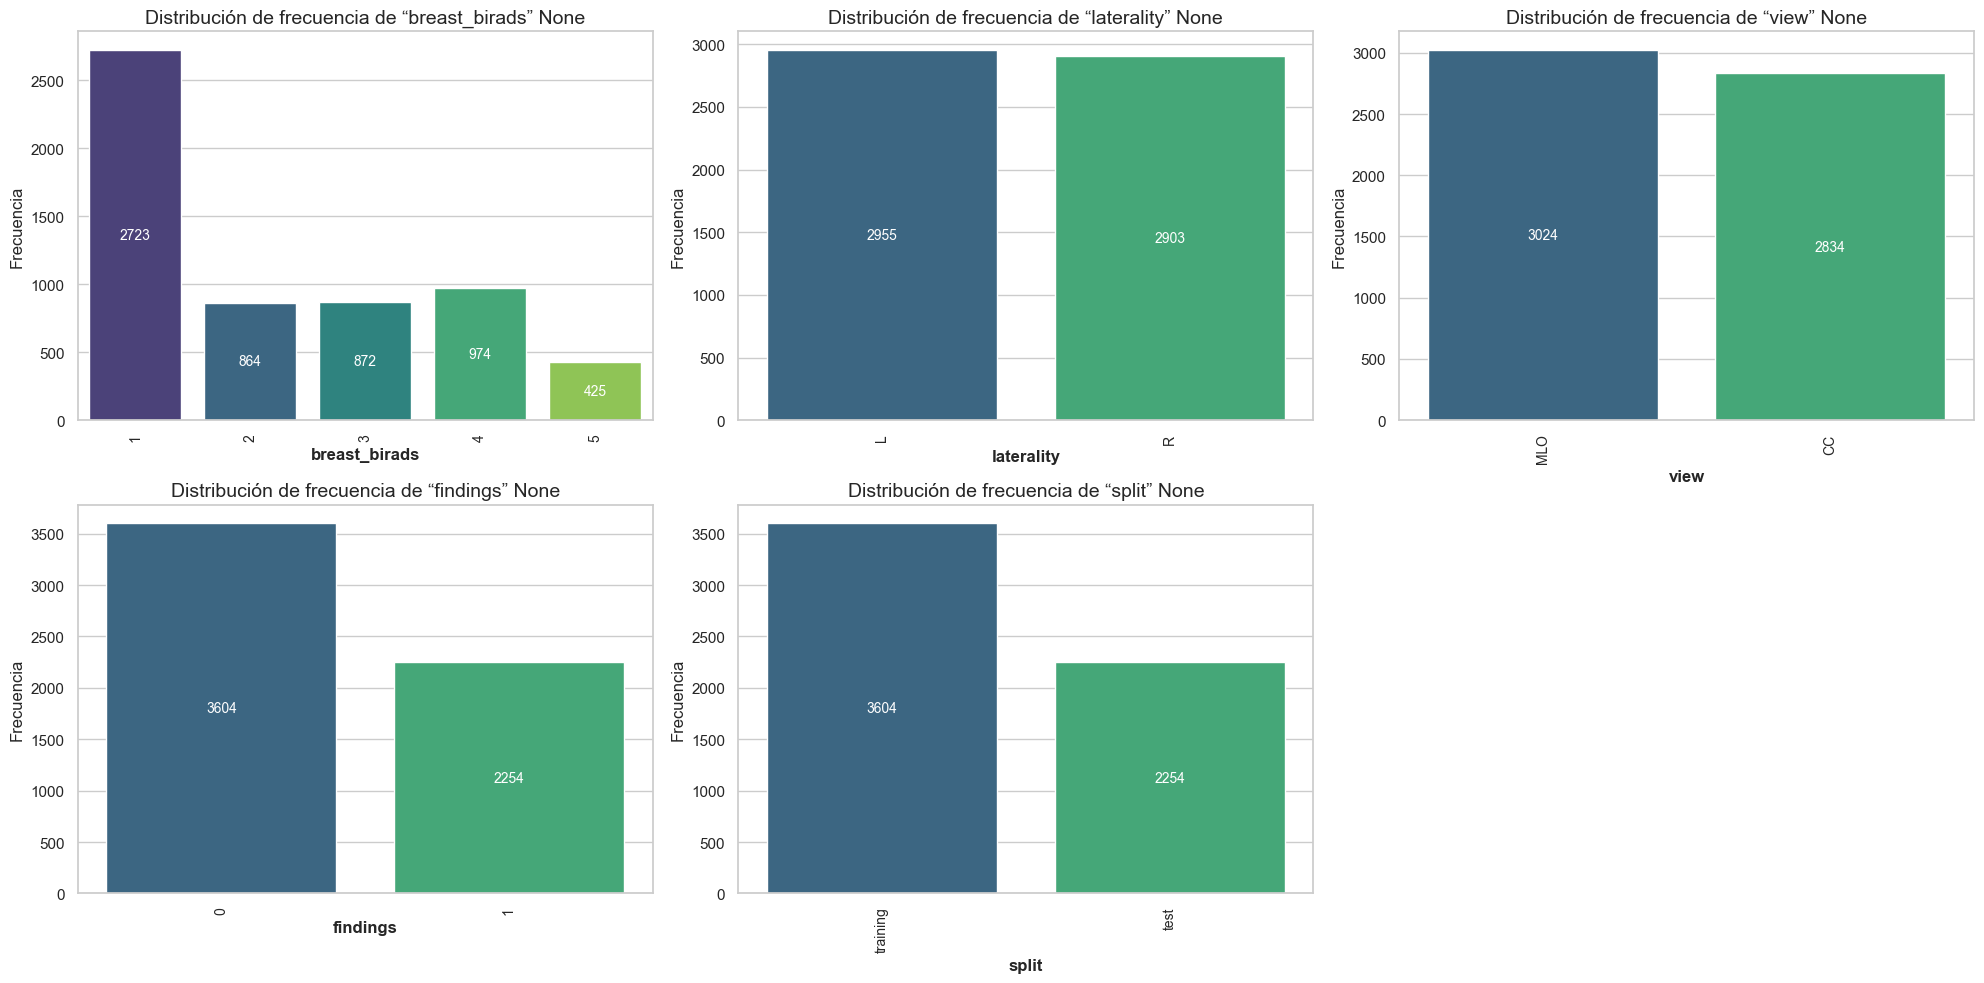

In [5]:
dataset.stats()

In [6]:
# from google.colab import auth
# auth.authenticate_user()
# !sudo pip install --no-cache-dir -U crcmod
# !gsutil cp gs://helen-data/dumps/dump_cache_reduced_half.npz ./

In [6]:
dataset.load_dump('dump_cache_balanced.npz')
# dataset.load_dump('dump_cache_reduced_half.npz')

In [8]:
# dataset.stats()

In [8]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 500

In [10]:
import gc
import time
import random
import numpy as np
import optuna
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Dividir dataset una sola vez
full_train = dataset[(dataset["split"] == "training")]
ds_test    = dataset[(dataset["split"] == "test")]
ds_train, ds_val = train_test_split(
    full_train,
    test_size=0.20,
    random_state=42,
    stratify=full_train["findings"]
)

def objective(trial):
    # ==== SEEDS PARA REPRODUCIBILIDAD ====
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

    # ==== COMET ====
    experiment = Experiment(
        api_key="W8IluWhLfvXgLr8ggg1bwZKTf",
        project_name="analisis",
        workspace="emiliodelgadouy",
        auto_output_logging="simple",
        log_code=False
    )
    experiment.set_name(f"trial_balanced_{trial.number}")

    # ==== HIPERPARÁMETROS ====
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate  = trial.suggest_float('dropout_rate', 0.2, 0.6)
    l2_reg        = trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True)
    unfreeze_pct  = trial.suggest_float("unfreeze_pct", 0.0, 0.3)
    optimizer     = Adam(learning_rate=learning_rate)

    experiment.log_parameters({
        "learning_rate": learning_rate,
        "dropout_rate": dropout_rate,
        "l2_reg": l2_reg,
        "backbone": "InceptionV3",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS,
        "unfreeze_pct": unfreeze_pct
    })

    # ==== GENERADORES ====
    train_generator = PatchSequence(
        ds_train,
        batch_size=BATCH_SIZE,
        patch_size=IMG_SIZE,
        shuffle=True,
        preprocess_fn=preprocess_input
    )
    val_generator = PatchSequence(
        ds_val,
        batch_size=BATCH_SIZE,
        patch_size=IMG_SIZE,
        shuffle=False,
        preprocess_fn=preprocess_input
    )
    test_generator = PatchSequence(
        ds_test,
        batch_size=BATCH_SIZE,
        patch_size=IMG_SIZE,
        shuffle=False,
        preprocess_fn=preprocess_input
    )

    # ==== BACKBONE ====
    base = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    for layer in base.layers:
        layer.trainable = False

    # Unfreeze parcial
    n_total = len(base.layers)
    n_unfreeze = int(n_total * unfreeze_pct)
    if n_unfreeze > 0:
        for layer in base.layers[-n_unfreeze:]:
            layer.trainable = True

    # ==== PESOS DE CLASE ====
    labels = np.array(ds_train["findings"])
    classes = np.unique(labels)
    weights = class_weight.compute_class_weight('balanced', classes=classes, y=labels)
    class_weights = dict(zip(classes, weights))

    # ==== CABEZA DEL MODELO ====
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(
        512,
        activation='relu',
        kernel_regularizer=l1_l2(l1=1e-4, l2=l2_reg)
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc_roc', curve='ROC')]
    )

    # ==== ENTRENAMIENTO ====
    t0 = time.time()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weights,
        verbose=1
    )
    elapsed = time.time() - t0
    experiment.log_metric("training_time_sec", elapsed)

    # ==== EVALUACIÓN EN TEST ====
    score = model.evaluate(test_generator, verbose=1)
    experiment.log_metric("final_test_loss", score[0])
    experiment.log_metric("final_test_accuracy", score[1])
    experiment.log_metric("final_test_auc_roc", score[2])

    experiment.end()

    # ==== LIBERAR MEMORIA ====
    del model, train_generator, val_generator, test_generator
    tf.keras.backend.clear_session()
    gc.collect()

    return score[1]


In [ ]:
study = optuna.create_study(direction='maximize', study_name='optuna_inception')
study.optimize(objective, n_trials=20)

print("accuracy", study.best_value)
print("params", study.best_params)

[I 2025-08-12 23:24:06,346] A new study created in memory with name: optuna_inception
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
